# Fourier Features
This notebook implements the concepts from the [Multi-Objective Loss Balancing for Physics-Informed Deep Learning paper](https://arxiv.org/abs/2110.09813) and [Improving PINNs through Adaptive Loss Balancing medium article](https://medium.com/p/55662759e701). It showcases the gains in performance when applying Loss Balancing Schemes to PINN training.



In [ ]:
pip install --upgrade tf_fourier_features

In [ ]:
pip install --upgrade tf_fourier_features[tests]

In [ ]:
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

from typing import Tuple, Callable, List, Union
from tensorflow.experimental.numpy import isclose
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tf_fourier_features import FourierFeatureProjection
from tf_fourier_features import FourierFeatureMLP

## Utility functions
We start by defining a few utility functions that will be useful later. The first, *compute_derivatives*, computes all the derivatives necessary to formulate the Helmholtz PINN objective (it is a second order differential equation).



In [ ]:
def compute_derivatives(x, y, u):
    """
    Computes the derivatives of `u` with respect to `x` and `y`.

    Parameters
    ----------
    x : tf.Tensor
        The x-coordinate of the collocation points, of shape (batch_size, 1).
    y : tf.Tensor
        The y-coordinate of the collocation points, of shape (batch_size, 1).
    u : tf.Tensor
        The prediction made by the PINN, of shape (batch_size, 1).

    Returns
    -------
    tuple
        The second order derivatives of `u` with respect to `x`, `y`.
    """
    dudx, dudy = tf.gradients(u, [x, y])
    dudxx = tf.gradients(dudx, x)[0]
    dudyy = tf.gradients(dudy, y)[0]
    return dudxx, dudyy


# def compute_derivatives(x, y, u):
#     """
#     Computes the derivatives of `u` with respect to `x` and `y` using tf.GradientTape
#     for eager execution compatibility.

#     Parameters
#     ----------
#     x : tf.Tensor
#         The x-coordinate of the collocation points, of shape (batch_size, 1).
#     y : tf.Tensor
#         The y-coordinate of the collocation points, of shape (batch_size, 1).
#     u : tf.Tensor
#         The prediction made by the PINN, of shape (batch_size, 1).

#     Returns
#     -------
#     tuple
#         The second order derivatives of `u` with respect to `x`, `y`.
#     """
#     with tf.GradientTape(persistent=True) as tape:
#         tape.watch(x)
#         tape.watch(y)
#         dudx, dudy = tape.gradient(u, [x, y])

#     dudxx = tape.gradient(dudx, x)
#     dudyy = tape.gradient(dudy, y)

#     del tape  # Drop the reference to the tape

#     return dudxx, dudyy

## Define a class for Fourier Features

In [ ]:
# class FourierFeatures(tf.keras.layers.Layer):
#     def __init__(self, B, **kwargs):
#         """
#         Initialize the Fourier Features layer.

#         Parameters:
#         B (tf.Tensor): A tensor of shape (n_features, 2) representing the frequencies used
#                        for the sine and cosine transformations.
#         """
#         super(FourierFeatures, self).__init__(**kwargs)
#         self.B = B

#     def call(self, inputs):
#         """
#         Apply Fourier Features transformation.

#         Parameters:
#         inputs (tf.Tensor): The input coordinates of shape (batch_size, 2).

#         Returns:
#         tf.Tensor: The transformed features.
#         """
#         x = tf.concat([tf.sin(tf.matmul(inputs, self.B)), tf.cos(tf.matmul(inputs, self.B))], axis=-1)
#         return x


# class FourierFeatures(tf.keras.layers.Layer):
#     def __init__(self, B, **kwargs):
#         super(FourierFeatures, self).__init__(**kwargs)
#         self.B = tf.constant(B, dtype=tf.float32)  # Ensure B is a TensorFlow constant

#     def call(self, inputs):
#         batch_size = tf.shape(inputs)[0]
#         inputs = tf.cast(inputs, dtype=tf.float32)  # Ensure inputs are float32
#         x, y = inputs[:, 0:1], inputs[:, 1:2]
#         x_features = tf.concat([tf.sin(x * self.B[0, :]), tf.cos(x * self.B[0, :])], axis=-1)
#         y_features = tf.concat([tf.sin(y * self.B[1, :]), tf.cos(y * self.B[1, :])], axis=-1)
#         return tf.concat([x_features, y_features], axis=-1)

## Define Helmholtz PDE Class (cas (a) avec une source en produit de sinus -> résoluble)

The Helmholtz equation is a partial differential equation that describes the propagation of waves in a medium. It is a second-order equation and named after the German physicist Hermann von Helmholtz. We can define the problem such that there exists an analytical solution, against which we can compare our PINN:

$$
    f(x, y) = (-\pi^2 - (4\pi)^2 + k^2) sin(\pi x) sin(4 \pi y) \\
    u(x, y) = sin(\pi x) sin(4 \pi y)\\
    u(-1, y) = u(1, y) = u(x, -1) = u(x, 1) = 0\\
$$
We consider the case where k = 1.

This class represents the [Helmholtz PDE](https://en.wikipedia.org/wiki/Helmholtz_equation). It provides a set of utility functions to train a [Physics Informed Neural Network (PINN)](https://arxiv.org/pdf/1711.10566.pdf) on the Helmholtz PDE. The class has functions that generate training and validation data, calculate loss, and visualize the results of the PINN's predictions.

In [ ]:
EPS = 1e-7

class HelmholtzPDE:
    """
    Class representing a Helmholtz pde, providing several methods for training a Physics-Informed Neural Network.
    """
    def __init__(self, u_val: Callable[[tf.Tensor, tf.Tensor], tf.Tensor]):
        """
        Initialize the HelmholtzPDE class.

        PARAMETERS
        ----------------
        u_val : Callable[[tf.Tensor, tf.Tensor], tf.Tensor]
            A function to validate the predictions.
        """
        self.u_val = u_val
        self.k = 2*np.pi
        self.num_terms = 2

    def training_batch(self, batch_size_domain:int=4000, batch_size_boundary:int=100) -> Tuple[tf.Tensor, tf.Tensor]:
        """
        Generates a batch of collocation points by randomly sampling `batch_size_domain` points inside the domain
        and `batch_size_boundary` points on each of the four boundaries.

        PARAMETERS
        --------------------
        batch_size_domain : int
            number of points to be sampled inside of the domain
        batch_size_boundary : int
            number of points to be sampled on each of the four boundaries
        """
        x_in =  tf.random.uniform(shape=(batch_size_domain, 1), minval=-1, maxval=1)
        x_b1 = -tf.ones(shape=(batch_size_boundary, 1))
        x_b2 =  tf.ones(shape=(batch_size_boundary, 1))
        x_b3 =  tf.random.uniform(shape=(batch_size_boundary, 1), minval=-1, maxval=1)
        x_b4 =  tf.random.uniform(shape=(batch_size_boundary, 1), minval=-1, maxval=1)
        x = tf.concat([x_in, x_b1, x_b2, x_b3, x_b4], axis=0)

        y_in =  tf.random.uniform(shape=(batch_size_domain, 1), minval=-1, maxval=1)
        y_b1 =  tf.random.uniform(shape=(batch_size_boundary, 1), minval=-1, maxval=1)
        y_b2 =  tf.random.uniform(shape=(batch_size_boundary, 1), minval=-1, maxval=1)
        y_b3 = -tf.ones(shape=(batch_size_boundary, 1))
        y_b4 =  tf.ones(shape=(batch_size_boundary, 1))
        y = tf.concat([y_in, y_b1, y_b2, y_b3, y_b4], axis=0)

        return x, y

    def get_train_dataset(self, batch_size_domain:int=4000, batch_size_boundary:int=100):
        """
        Creates a tf.data.Dataset generator for training.

        Parameters
        ----------
        batch_size_domain : int
            number of points to be sampled inside of the domain. Default is 800.
        batch_size_boundary : int
            number of points to be sampled on each of the four boundaries. Default is 100.

        Returns
        -------
        tf.data.Dataset
            A `tf.data.Dataset` generator for training.
        """
        def generator():
            while True:
                xy = tf.concat(self.training_batch(batch_size_domain, batch_size_boundary), axis=-1)
                yield xy, xy

        return tf.data.Dataset.from_generator(
            generator,
            output_types=(tf.float32, tf.float32),
            output_shapes=((None, 2), (None, 2))
        )

    def validation_batch(self, grid_width:int=64, grid_height:int=64):
        """
        Generates a grid of points that can easily be used to generate an image of the pde,
        where each point is a pixel.

        PARAMETERS
        ----------
        grid_width : int
            width of the grid
        grid_height : int
            height of the grid
        """
        x, y = np.mgrid[-1:1:complex(0, grid_width), -1:1:complex(0, grid_height)]
        x = tf.cast(x.reshape(grid_width * grid_height, 1), dtype=tf.float32)
        y = tf.cast(y.reshape(grid_width * grid_height, 1), dtype=tf.float32)
        u = tf.math.sin(np.pi * x) * tf.math.sin(4 * np.pi * y)
        return x, y, u

    def compute_loss(self, x, y, preds, eval=False):
        """
        Computes the physics-informed loss for Helmholtz's PDE.

        Parameters
        ----------
        x : tf.Tensor of shape (batch_size, 1)
            x coordinate of the points in the current batch
        y : tf.Tensor of shape (batch_size, 1)
            y coordinate of the points in the current batch
        preds : tf.Tensor of shape (batch_size, 6)
            predictions made by our PINN (dim 0) as well as dudxx (dim 1), dudyy (dim 2)
        """

        # governing equation loss
        L_f = (preds[:, 1:2] + preds[:, 2:3] + self.k**2 * preds[:, 0:1] - \
              (-np.pi**2 - (4 * np.pi)**2 + self.k**2) * tf.math.sin(np.pi * x) * tf.math.sin(4 * np.pi * y))**2

        # determine which points are on the boundaries of the domain
        # if a point is on either of the boundaries, its value is 1 and 0 otherwise
        x_lower = tf.cast(isclose(x, -1, rtol=0., atol=EPS), dtype=tf.float32)
        x_upper = tf.cast(isclose(x,  1, rtol=0., atol=EPS), dtype=tf.float32)
        y_lower = tf.cast(isclose(y, -1, rtol=0., atol=EPS), dtype=tf.float32)
        y_upper = tf.cast(isclose(y,  1, rtol=0., atol=EPS), dtype=tf.float32)

        # compute 0th order boundary condition loss
        L_b = ((x_lower + x_upper + y_lower + y_upper) * preds[:, 0:1])**2

        if eval:
            L_u = (tf.math.sin(np.pi*x) * tf.math.sin(4*np.pi*y) - preds[:, 0:1])**2
            return L_f, L_b, L_u

        return L_f, L_b

    @tf.function
    def __validation_results(self, pinn: tf.keras.Model, image_width: int = 64, image_height: int = 64):
        """Computes the validation results for the given model.

        Parameters
        ----------
        pinn : tf.keras.Model
            A TensorFlow Keras model instance.
        image_width : int
            The width of the image (defaults to 64).
        image_height : int
            The height of the image (defaults to 64).

        Returns:
        u_real : tf.Tensor
            A tensor containing the real displacement.
        u_pred : tf.Tensor
            A tensor containing the predicted displacement.
        f : tf.Tensor
            A tensor containing the governing equation.
        """
        x, y, u_real = self.validation_batch(image_width, image_height)
        pred = pinn(tf.concat([x, y], axis=-1), training=False)
        u_pred, dudxx, dudyy = pred[:, 0:1], pred[:, 1:2], pred[:, 2:3]
        sin_xy = tf.math.sin(np.pi*x) * tf.math.sin(4*np.pi*y)
        f = (dudxx + dudyy + self.k * u_pred - (-np.pi**2 - (4*np.pi)**2 + self.k**2) * sin_xy)**2
        return u_real, u_pred, f


    def visualise(self, pinn: tf.keras.Model = None, image_width: int = 64, image_height: int = 64):
        """
        If no model is provided, visualises only the load distribution on the plate.
        Otherwise, visualizes the results of the given model.

        Parameters
        ----------
        pinn : tf.keras.Model
            A TensorFlow Keras model instance.
        image_width : int
            The width of the image (defaults to 64).
        image_height : int
            The height of the image (defaults to 64).
        """
        if pinn is None:
            x, y, u_real = self.validation_batch(image_width, image_height)
            self.__show_image(u_real.numpy().reshape(image_width, image_height))
            plt.show()

        else:
            u_real, u_pred, f = self.__validation_results(pinn, image_width, image_height)
            u_real = u_real.numpy().reshape(image_width, image_height)
            u_pred = u_pred.numpy().reshape(image_width, image_height)
            f = f.numpy().reshape(image_width, image_height)

            fig, axs = plt.subplots(2, 2, figsize=(8, 7))
            self.__show_image(u_pred, axs[0, 0], 'Predicted')
            self.__show_image((u_pred - u_real)**2, axs[0, 1], 'Squared Error')
            self.__show_image(f, axs[1, 0], 'Governing Equation')
            self.__show_image(f**2, axs[1, 1], 'Squared Error Governing Equation')

            # Hide x labels and tick labels for top plots and y ticks for right plots.
            for ax in axs.flat:
                ax.label_outer()
            plt.tight_layout()
            plt.show()

    def __show_image(self, img:np.array, axis:plt.axis=None, title:str='', x_label='x', y_label='y', z_label=''):
        if axis is None:
             _, axis = plt.subplots(1, 1, figsize=(4, 3.2), dpi=100)
        im = axis.imshow(np.rot90(img, k=3), cmap='plasma', origin='lower', aspect='auto')
        cb = plt.colorbar(im, label=z_label, ax=axis)
        axis.set_xticks([0, img.shape[0]-1])
        axis.set_xticklabels([-1, 1])
        axis.set_yticks([0, img.shape[1]-1])
        axis.set_yticklabels([-1, 1])
        axis.set_xlabel(x_label)
        axis.set_ylabel(y_label)
        axis.set_title(title)
        return im

## Helmholtz PINN Loss Function

### Default Helmholtz PDE Loss
This class inherits from the keras Loss class and can be used in the keras API (i.e. model.fit()) for training our Helmholtz PINN.

In [ ]:
class HelmholtzLoss(tf.keras.losses.Loss):
    """
    Helmholtz Loss for physics-informed neural network.

    Parameters
    ----------
    pde: HelmholtzPDE
        The HelmholtzPDE object representing the PDE
        The name of the loss, by default 'ReLoBRaLoHelmholtzLoss'
    """
    def __init__(self, pde:HelmholtzPDE, name='HelmholtzLoss'):
        super().__init__(name=name)
        self.pde = pde

    def call(self, xy, preds):
        x, y = xy[:, :1], xy[:, 1:]
        L_f, L_b = self.pde.compute_loss(x, y, preds)
        loss = L_f + L_b
        return tf.reduce_mean(loss)

## Metrics for logging

### Custom Metric for logging Helmholtz Loss Terms

In [ ]:
class HelmholtzMetric(tf.keras.metrics.Metric):
    """
    Helmholtz metric to log the values of each loss term, i.e. L_f and L_b.
    """
    def __init__(self, pde: HelmholtzPDE, name='Helmholtz_metric', **kwargs):
        """Initialize Helmholtz metric with a HelmholtzPDE instance and metric name.

        Parameters
        ----------
        pde : HelmholtzPDE
            Instance of the HelmholtzPDE.
        name : str, optional
            Name of the metric. Defaults to 'Helmholtz_metric'.
        """
        super().__init__(name=name, **kwargs)
        self.pde = pde
        self.L_f_mean = self.add_weight(name='L_f_mean', initializer='zeros')
        self.L_b_mean = self.add_weight(name='L_b_mean', initializer='zeros')
        self.L_u_mean = self.add_weight(name='L_u_mean', initializer='zeros')

    def update_state(self, xy, y_pred, sample_weight=None):
        x, y = xy[:, :1], xy[:, 1:]
        L_f, L_b, L_u = self.pde.compute_loss(x, y, y_pred, eval=True)
        self.L_f_mean.assign(tf.reduce_mean(L_f[:, 0], axis=0))
        self.L_b_mean.assign(tf.reduce_mean(L_b[:, 0], axis=0))
        self.L_u_mean.assign(tf.reduce_mean(L_u[:, 0], axis=0))

    def reset_state(self):
        self.L_f_mean.assign(0)
        self.L_b_mean.assign(0)
        self.L_u_mean.assign(0)

    def result(self):
        return {'L_f': self.L_f_mean, 'L_b': self.L_b_mean, 'L_u': self.L_u_mean}

## PINN Model

In [ ]:
# class HelmholtzPINN(tf.keras.Model):
#     def __init__(self, B, layer_widths=[64, 64, 64], activation='tanh', **kwargs):
#         """
#         Parameters:
#         B (tf.Tensor): A tensor of shape (n_features, 2) representing the frequencies used
#                        for the Fourier Features transformations.
#         layer_widths (List[int]): List of integers representing the widths of the hidden layers.
#         activation (str or Callable): Activation function for the hidden layers.
#         """
#         super(HelmholtzPINN, self).__init__(**kwargs)
#         self.fourier_features = FourierFeatures(B)
#         self.layer_sequence = [tf.keras.layers.Dense(width, activation=activation, kernel_initializer='glorot_normal') for width in layer_widths]
#         self.layer_sequence.append(tf.keras.layers.Dense(1, kernel_initializer='glorot_normal'))

#     def call(self, xy, training=None, mask=None):
#         xy_transformed = self.fourier_features(xy)

#         u = xy_transformed
#         for layer in self.layer_sequence:
#             u = layer(u)

#         # Compute derivatives as before
#         x, y = xy[:, :1], xy[:, 1:]
#         dudxx, dudyy = compute_derivatives(x, y, u)

#         return tf.concat([u, dudxx, dudyy], axis=-1)

## Problem definition
Define the problem such that there exists an analytical solution, against which we can compare our PINN:

$$
    u(x, y) = sin(\pi x) sin(4 \pi y)\\
$$

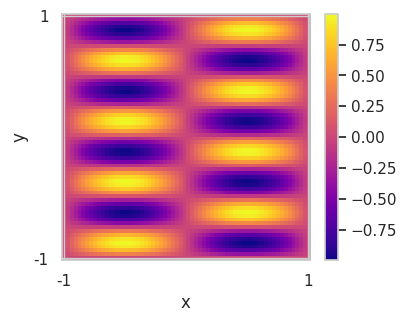

In [ ]:
u_val = lambda x, y: tf.math.sin(x * np.pi) * tf.math.sin(4 * y * np.pi)
pde = HelmholtzPDE(u_val=u_val)
pde.visualise()

### Train without loss balancing
Now that the PDE has been defined, we can build the model as well as the loss function. We are first using the default HelmholtzLoss and will compare it to the ReLoBRaLoHelmholtzLoss later.

In [ ]:
# num_features = 64
# B = np.random.normal(size=(2, num_features))
# B_tensor = tf.constant(B, dtype=tf.float32)

In [ ]:
pinn = FourierFeatureMLP(units=5, final_units=3, activation='tanh', final_activation='tanh', gaussian_projection=64, num_layers=4, gaussian_scale=30.0)
loss = HelmholtzLoss(pde)
pinn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=loss, metrics=[HelmholtzMetric(pde)], run_eagerly=True)

In [ ]:
h = pinn.fit(
    pde.get_train_dataset(),
    epochs=800,  #was 1000
    steps_per_epoch=100
)

Epoch 1/800
100/100 [==============================] - 16s 139ms/step - loss: 4554.8906 - L_f: 4548.3792 - L_b: 0.0449 - L_u: 0.7293
Epoch 2/800
100/100 [==============================] - 8s 84ms/step - loss: 3752.9993 - L_f: 3752.7312 - L_b: 9.9881e-04 - L_u: 0.2395
Epoch 3/800
100/100 [==============================] - 6s 59ms/step - loss: 3717.9365 - L_f: 3719.0735 - L_b: 5.0752e-04 - L_u: 0.2413
Epoch 4/800
100/100 [==============================] - 6s 60ms/step - loss: 3701.6680 - L_f: 3702.4541 - L_b: 0.0017 - L_u: 0.2742
Epoch 5/800
100/100 [==============================] - 6s 59ms/step - loss: 3662.6123 - L_f: 3662.3176 - L_b: 0.0023 - L_u: 0.2895
Epoch 6/800
100/100 [==============================] - 6s 60ms/step - loss: 3663.5098 - L_f: 3663.0987 - L_b: 0.0024 - L_u: 0.2965
Epoch 7/800
100/100 [==============================] - 6s 60ms/step - loss: 3631.4924 - L_f: 3631.9072 - L_b: 0.0030 - L_u: 0.3164
Epoch 8/800
100/100 [==============================] - 6s 61ms/step - los

Visualise the progress of the several loss terms as well as the error against the analytical solution.

In [ ]:
fig = plt.figure(figsize=(6, 4.5), dpi=100)
plt.plot(np.log(h.history['L_f'])[:300], label='$L_f$ governing equation')
plt.plot(np.log(h.history['L_b'])[:300], label='$L_{b}$ Dirichlet boundaries')
plt.plot(np.log(h.history['L_u'])[:300], label='$L_u$ analytical solution')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Log-loss')
plt.title('Loss evolution Helmholtz PDE')
plt.show()

Visually inspect the error distribution on the physical domain.

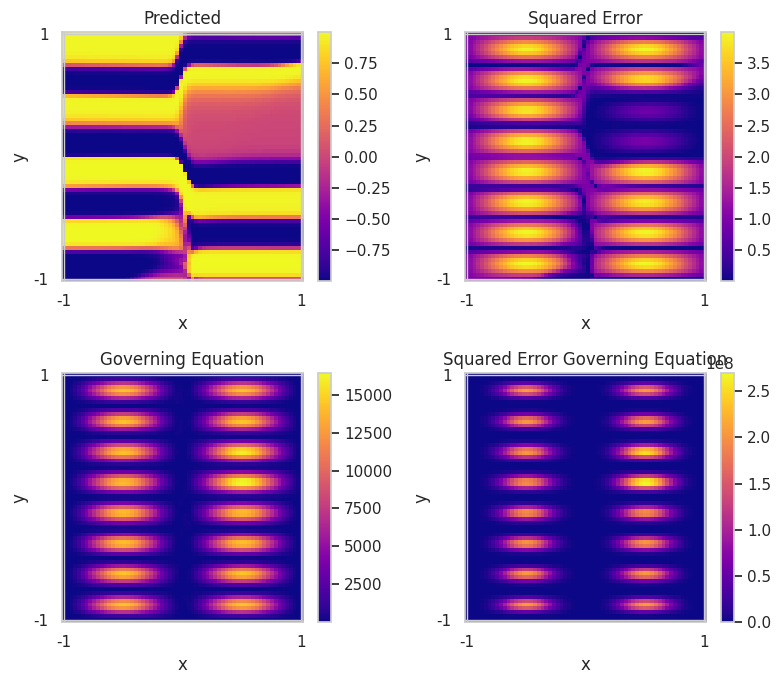

In [ ]:
pde.visualise(pinn)